In [1]:
import os
import pandas as pd
import numpy as np

from tensorflow.random import set_seed

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Set seeds

In [2]:
np.random.seed(42)
set_seed(42)

# Objective

The client has a number of industrial assets equipped with sensors. The aim is to use the data to predict the operational mode of the asset. The client would like an accurate model to infer all modes but is particularly interested in modes e and f which are thought by the operators to indicate impending failure.

# Process data

Get the file path and load the data

In [3]:
path_to_data=os.path.join(os.getcwd(), "data/raw_data.csv")

In [4]:
df = pd.read_csv(path_to_data, index_col=0)

/Users/edd/opt/anaconda3/envs/ame/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.head()

,asset_id,operational_mode,s1,s2,s3
2016-01-01 00:00:00,20,b,5.41,13.21,-4.630918
2016-01-01 00:05:00,20,b,6.74,8.16,0.95342433
2016-01-01 00:10:00,20,b,5.33,5.37,-2.7921712000000003
2016-01-01 00:15:00,20,b,3.38,8.54,-1.525479
2016-01-01 00:20:00,20,b,1.73,9.11,-0.9942854


Operational mode is our target variable so we make that a proper categorical variable

In [6]:
df.operational_mode = pd.Categorical(df.operational_mode)

df.head()

,asset_id,operational_mode,s1,s2,s3
2016-01-01 00:00:00,20,b,5.41,13.21,-4.630918
2016-01-01 00:05:00,20,b,6.74,8.16,0.95342433
2016-01-01 00:10:00,20,b,5.33,5.37,-2.7921712000000003
2016-01-01 00:15:00,20,b,3.38,8.54,-1.525479
2016-01-01 00:20:00,20,b,1.73,9.11,-0.9942854


We can also make the timestamp index an actual timestamp.

In [7]:
df = df.set_index(pd.to_datetime(df.index))

Force the sensor data to be numeric.

In [8]:
df[['s1', 's2', 's3']] = df[['s1', 's2', 's3']].apply(pd.to_numeric, errors='coerce')

Check for null values

In [9]:
df[['s1', 's2', 's3']].isnull().sum()

s1    5
s2    7
s3    6
dtype: int64

We don't have many, perhaps just fill the values forward is best.

In [10]:
df = df.fillna(method='ffill')

# Exploration
Now explore the development set. Look at mode prevalence...

<AxesSubplot:>

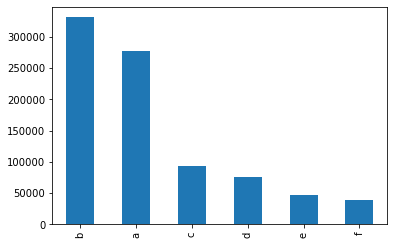

In [11]:
df.operational_mode.value_counts().plot.bar()

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

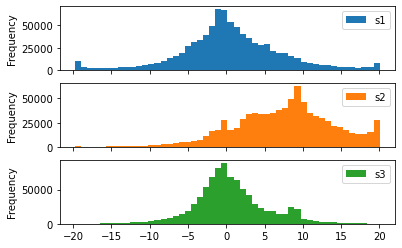

In [12]:
df[['s1', 's2', 's3']].plot.hist(bins=50, subplots=True)

Looks like we should use all the sensors here.

Change the dataframe to tall format for seaborn plotting

In [13]:
tall_df = df.reset_index().melt(value_vars=["s1", "s2", "s3"], 
                                id_vars=["index", "asset_id", "operational_mode"],
                                var_name="sensor")
tall_df.head()

,index,asset_id,operational_mode,sensor,value
0,2016-01-01 00:00:00,20,b,s1,5.41
1,2016-01-01 00:05:00,20,b,s1,6.74
2,2016-01-01 00:10:00,20,b,s1,5.33
3,2016-01-01 00:15:00,20,b,s1,3.38
4,2016-01-01 00:20:00,20,b,s1,1.73


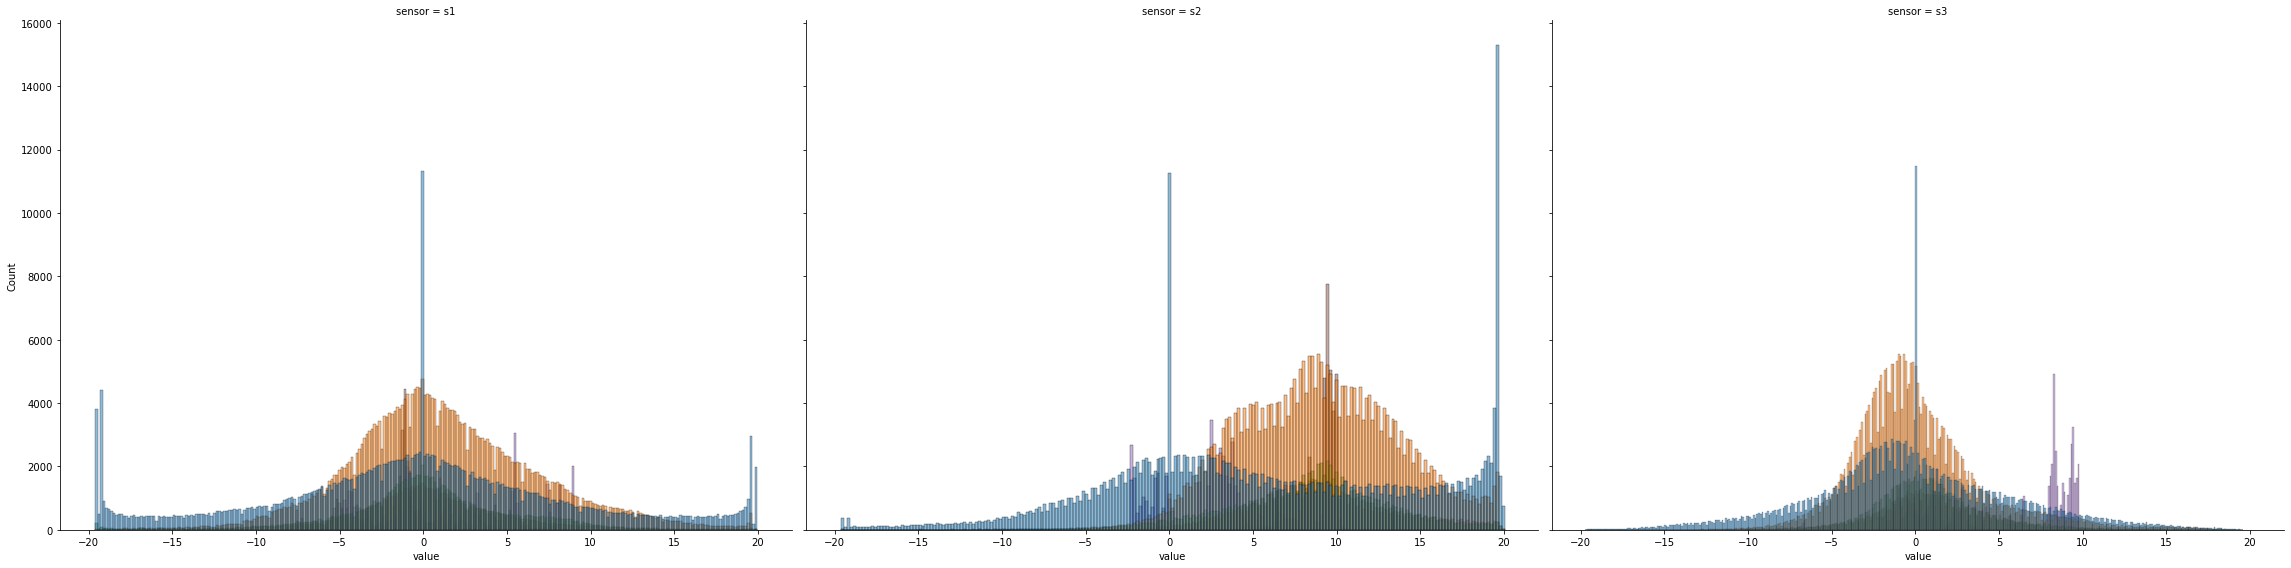

In [14]:
fig = sns.FacetGrid(tall_df, col="sensor", height=8, aspect= 1.33)
fig.map_dataframe(sns.histplot, x="value", hue="operational_mode")

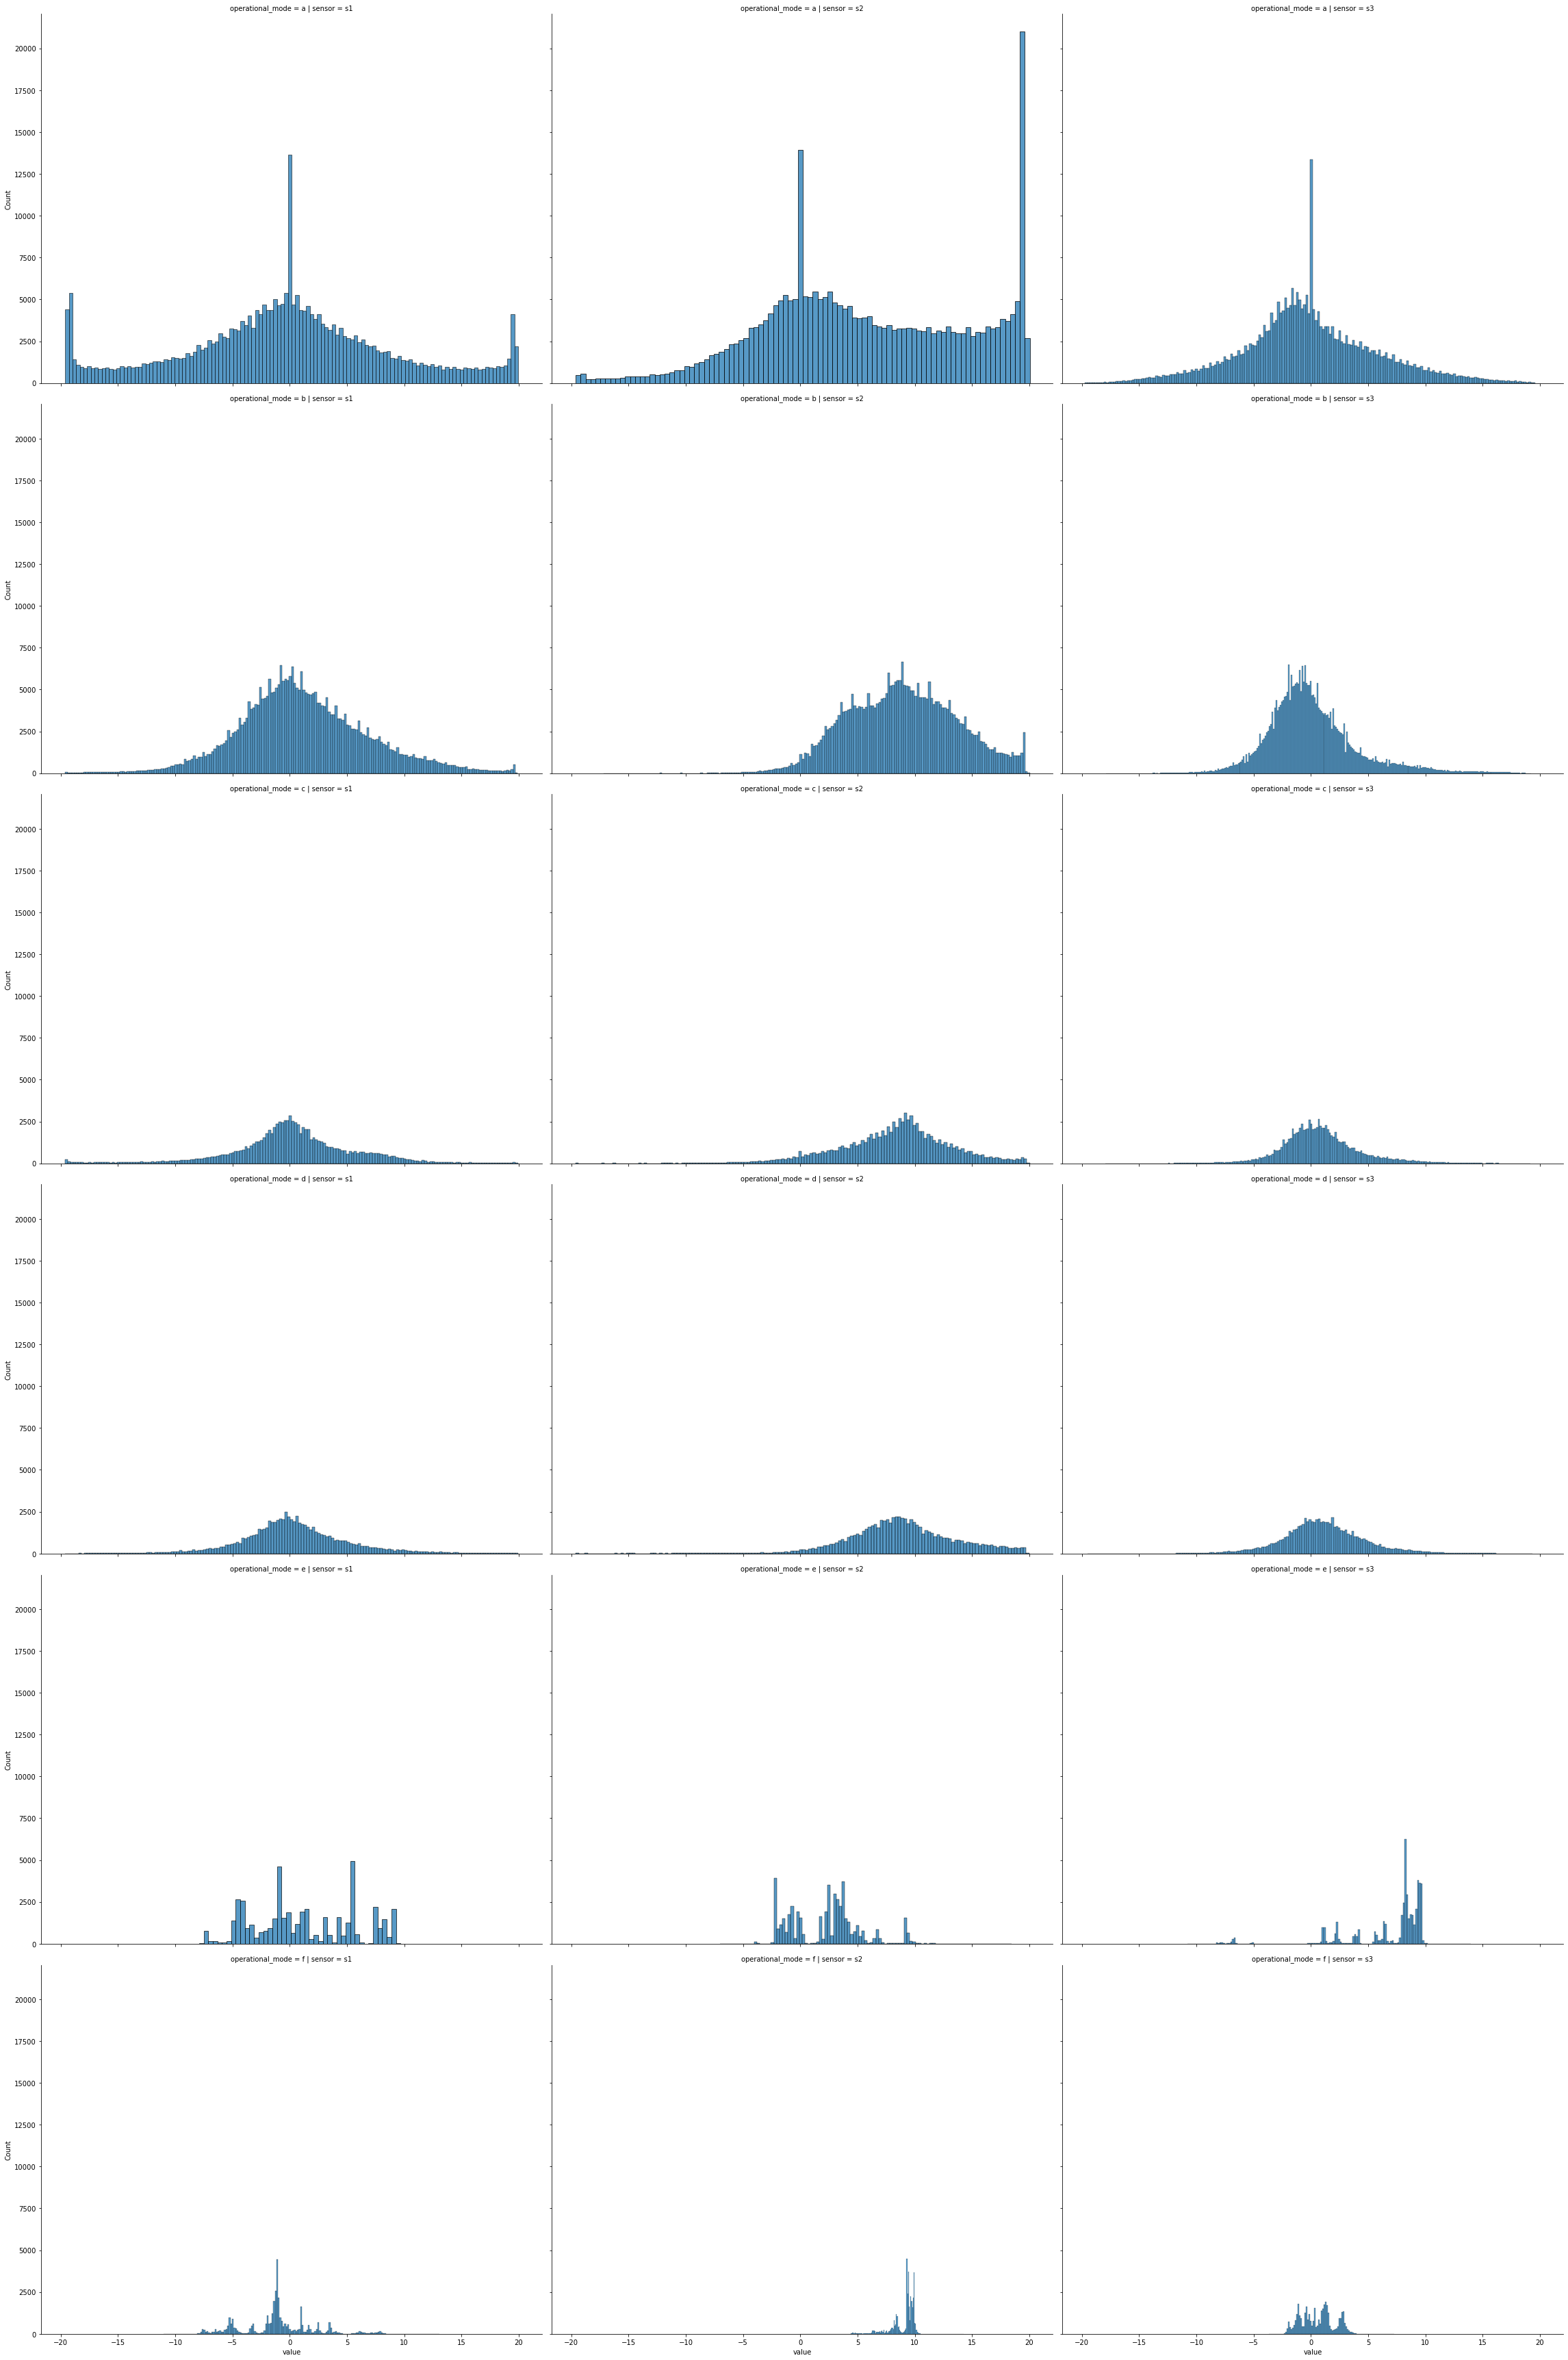

In [15]:
fig = sns.FacetGrid(tall_df, col="sensor",  row="operational_mode", height=8, aspect= 1.33)
fig.map_dataframe(sns.histplot, x="value")

Again, this enforces the use of all sensors. 

# Create train-validation splits

Same grouping method as before. We will have 6 of 24 assets (25%) as the validation set.

In [16]:
splitter = GroupShuffleSplit(n_splits=2, train_size=0.75, random_state=42)
train, validation = next(splitter.split(df, groups=df.asset_id))

In [17]:
train_df = df.iloc[train]
validation_df = df.iloc[validation]

train_path = os.path.join(os.getcwd(), "data/train_data.csv")
train_df.to_csv(train_path)

validation_path = os.path.join(os.getcwd(), "data/validation_data.csv")
validation_df.to_csv(validation_path)

# Create input tensors

These are needed for the deep learning model.

Scale the data first.

In [18]:
scaler = MinMaxScaler()

scaled_train_df = pd.DataFrame(scaler.fit_transform(train_df[['s1', 's2', 's3']]),
                                index=train_df.index,
                                columns=['s1_scaled', 's2_scaled', 's3_scaled'])

scaled_validation_df = pd.DataFrame(scaler.transform(validation_df[['s1', 's2', 's3']]),
                                index=validation_df.index,
                                columns=['s1_scaled', 's2_scaled', 's3_scaled'])

train_df = pd.concat([train_df, scaled_train_df], axis=1)
validation_df = pd.concat([validation_df, scaled_validation_df], axis=1)

In [19]:
train_df.head()

,asset_id,operational_mode,s1,s2,s3,s1_scaled,s2_scaled,s3_scaled
2016-01-01 00:00:00,29,b,5.63,8.43,-2.873893,0.638018,0.707188,0.429967
2016-01-01 00:05:00,29,b,6.21,10.92,-1.566340,0.652679,0.769987,0.463340
2016-01-01 00:10:00,29,b,9.70,10.53,4.140586,0.740900,0.760151,0.608999
2016-01-01 00:15:00,29,b,7.40,10.57,1.416516,0.682760,0.761160,0.539472
2016-01-01 00:20:00,29,b,6.47,15.60,-3.486809,0.659252,0.888020,0.414323


In [20]:
validation_df.head()

,asset_id,operational_mode,s1,s2,s3,s1_scaled,s2_scaled,s3_scaled
2016-01-01 00:00:00,20,b,5.41,13.21,-4.630918,0.632457,0.827743,0.385122
2016-01-01 00:05:00,20,b,6.74,8.16,0.953424,0.666077,0.700378,0.527652
2016-01-01 00:10:00,20,b,5.33,5.37,-2.792171,0.630435,0.630013,0.432053
2016-01-01 00:15:00,20,b,3.38,8.54,-1.525479,0.581143,0.709962,0.464383
2016-01-01 00:20:00,20,b,1.73,9.11,-0.994285,0.539434,0.724338,0.477941


Now we can create the tensors.

- Each tensor uses the previous 200 data points.
- The next tensor starts and ends 200 data points after the previous
- All data points in a tensor belong to the same asset in the same operating mode

The code below uses a loop that selects each asset, then selects each operational mode, then creates every timeseries tensor it can from that asset's data in that particular operational mode.

In [21]:
window = 200
step = 200
X_train = []
y_train = []
asset_id_train = []

for asset in train_df.asset_id.unique(): 
    
    for mode in train_df[train_df.asset_id==asset].operational_mode.unique():
        
        mode_df = train_df[(train_df.asset_id==asset) 
                                & (train_df.operational_mode==mode)]
        
        for i in range(0, len(mode_df) - window, step):
            
            X_train.append(mode_df[['s1_scaled', 's2_scaled', 's3_scaled']].iloc[i: i+window].values)
            y_train.append(mode)
            asset_id_train.append(asset)
            
            
X_train = np.array(X_train)
y_train = pd.get_dummies(y_train).values
asset_id_train = np.array(asset_id_train)

Same for the validation data set

In [22]:
X_validation = []
y_validation = []
asset_id_validation = []

for asset in validation_df.asset_id.unique():
    
    for mode in validation_df[validation_df.asset_id==asset].operational_mode.unique():
        
        mode_df = validation_df[(validation_df.asset_id==asset) 
                                & (validation_df.operational_mode==mode)]
        
        for i in range(0, len(mode_df) - window, step):
            
            X_validation.append(mode_df[['s1_scaled', 's2_scaled', 's3_scaled']].iloc[i: i+window].values)
            y_validation.append(mode)
            asset_id_validation.append(asset)
            
X_validation = np.array(X_validation)
y_validation = pd.get_dummies(y_validation).values
asset_id_validation = np.array(asset_id_validation)

# Model training

The **cool** part

Below we define some parameters for out network.

In [23]:
epochs = 200 # number of training iterations for the network
batch_size = 1024 # for gradient descent optimisation
seq_len = X_train.shape[1] # number of observations in the dataset
learning_rate = 0.1 # learning rate for the optimiser
n_classes = y_train.shape[1] # number of target classes
n_channels = 3 # number of features in the data
nb_filters = 96 # number of convolutional neurons in the first layer, note subsequent layers are a function of this. 
layer_1_kernel_size = 5 # size of the kernel for the first CNN layer
kernel_size = 3 # size of the kernel for other layers
stride = 2 # number of timesteps to shift the kernel in the CNN
pad = "same" # how to pad the data if the kernel overlaps the end of the input tensor
dropout = 0.1 # dropout rate for layers prior to the final layer
final_dropout = 0.5 # dropout rate for the final layer

In [24]:
model = Sequential()
model.add(Convolution1D(nb_filters,
                        layer_1_kernel_size,
                        strides=stride,
                        kernel_constraint=max_norm(3),
                        bias_constraint=max_norm(3),
                        padding = pad,
                        activation = 'relu',
                        input_shape = (seq_len,n_channels)))
model.add(MaxPooling1D(pool_size =2, strides=stride, padding = pad))
model.add(Dropout(dropout))
model.add(Convolution1D(nb_filters*0.75, kernel_size, strides=stride, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), activation = 'relu', padding = pad))
model.add(MaxPooling1D(pool_size = 2, strides=stride, padding = pad))
model.add(Dropout(dropout))
model.add(Convolution1D(nb_filters*0.5,kernel_size, strides=stride, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), activation = 'relu', padding = pad))
model.add(MaxPooling1D(pool_size = 2, strides=stride, padding = pad))
model.add(Dropout(dropout))
model.add(Convolution1D(nb_filters*0.25, kernel_size, strides=stride, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), activation = 'relu', padding = pad))
model.add(MaxPooling1D(pool_size = 2, strides=stride, padding = pad))
model.add(Flatten())
model.add(Dropout(final_dropout))
model.add(Dense(n_classes, activation = 'sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-09-27 11:19:23.037821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# Fit model
history = model.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_validation, y_validation))

2021-09-27 11:19:23.185584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/200
4/4 [==============================] - 2s 412ms/step - loss: 1.7559 - accuracy: 0.2133 - val_loss: 1.6617 - val_accuracy: 0.2711
Epoch 2/200
4/4 [==============================] - 1s 153ms/step - loss: 1.6054 - accuracy: 0.3593 - val_loss: 1.5676 - val_accuracy: 0.2711
Epoch 3/200
4/4 [==============================] - 1s 153ms/step - loss: 1.5267 - accuracy: 0.3705 - val_loss: 1.5506 - val_accuracy: 0.4595
Epoch 4/200
4/4 [==============================] - 1s 159ms/step - loss: 1.5468 - accuracy: 0.3730 - val_loss: 1.5427 - val_accuracy: 0.4093
Epoch 5/200
4/4 [==============================] - 1s 154ms/step - loss: 1.5120 - accuracy: 0.3809 - val_loss: 1.5267 - val_accuracy: 0.5150
Epoch 6/200
4/4 [==============================] - 1s 155ms/step - loss: 1.4651 - accuracy: 0.4178 - val_loss: 1.5118 - val_accuracy: 0.3970
Epoch 7/200
4/4 [==============================] - 1s 155ms/step - loss: 1.4438 - accuracy: 0.4286 - val_loss: 1.4756 - val_accuracy: 0.5079
Epoch 8/200
4

Epoch 59/200
4/4 [==============================] - 1s 149ms/step - loss: 0.6461 - accuracy: 0.7793 - val_loss: 0.6454 - val_accuracy: 0.7887
Epoch 60/200
4/4 [==============================] - 1s 144ms/step - loss: 0.6225 - accuracy: 0.7950 - val_loss: 0.6449 - val_accuracy: 0.7905
Epoch 61/200
4/4 [==============================] - 1s 142ms/step - loss: 0.6227 - accuracy: 0.7827 - val_loss: 0.6967 - val_accuracy: 0.7482
Epoch 62/200
4/4 [==============================] - 1s 145ms/step - loss: 0.6632 - accuracy: 0.7874 - val_loss: 0.9018 - val_accuracy: 0.6637
Epoch 63/200
4/4 [==============================] - 1s 141ms/step - loss: 0.7326 - accuracy: 0.7430 - val_loss: 0.6674 - val_accuracy: 0.7632
Epoch 64/200
4/4 [==============================] - 1s 142ms/step - loss: 0.6328 - accuracy: 0.7785 - val_loss: 0.6872 - val_accuracy: 0.7597
Epoch 65/200
4/4 [==============================] - 1s 142ms/step - loss: 0.6313 - accuracy: 0.7783 - val_loss: 0.6607 - val_accuracy: 0.7641
Epoch 

4/4 [==============================] - 1s 150ms/step - loss: 0.4613 - accuracy: 0.8246 - val_loss: 0.5596 - val_accuracy: 0.7852
Epoch 117/200
4/4 [==============================] - 1s 152ms/step - loss: 0.4597 - accuracy: 0.8167 - val_loss: 0.5849 - val_accuracy: 0.8107
Epoch 118/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4703 - accuracy: 0.8212 - val_loss: 0.5221 - val_accuracy: 0.8125
Epoch 119/200
4/4 [==============================] - 1s 143ms/step - loss: 0.4537 - accuracy: 0.8262 - val_loss: 0.5573 - val_accuracy: 0.7975
Epoch 120/200
4/4 [==============================] - 1s 151ms/step - loss: 0.4673 - accuracy: 0.8254 - val_loss: 0.5779 - val_accuracy: 0.8204
Epoch 121/200
4/4 [==============================] - 1s 150ms/step - loss: 0.4450 - accuracy: 0.8330 - val_loss: 0.5344 - val_accuracy: 0.8090
Epoch 122/200
4/4 [==============================] - 1s 150ms/step - loss: 0.4202 - accuracy: 0.8352 - val_loss: 0.5367 - val_accuracy: 0.8195
Epoch 123/200

4/4 [==============================] - 1s 141ms/step - loss: 0.3398 - accuracy: 0.8691 - val_loss: 0.5817 - val_accuracy: 0.8134
Epoch 174/200
4/4 [==============================] - 1s 144ms/step - loss: 0.3628 - accuracy: 0.8532 - val_loss: 0.6068 - val_accuracy: 0.7984
Epoch 175/200
4/4 [==============================] - 1s 141ms/step - loss: 0.4212 - accuracy: 0.8389 - val_loss: 0.6896 - val_accuracy: 0.7623
Epoch 176/200
4/4 [==============================] - 1s 144ms/step - loss: 0.3798 - accuracy: 0.8403 - val_loss: 0.5360 - val_accuracy: 0.8327
Epoch 177/200
4/4 [==============================] - 1s 143ms/step - loss: 0.3558 - accuracy: 0.8549 - val_loss: 0.6182 - val_accuracy: 0.7975
Epoch 178/200
4/4 [==============================] - 1s 142ms/step - loss: 0.4521 - accuracy: 0.8326 - val_loss: 0.6636 - val_accuracy: 0.7526
Epoch 179/200
4/4 [==============================] - 1s 142ms/step - loss: 0.4323 - accuracy: 0.8253 - val_loss: 0.6580 - val_accuracy: 0.7870
Epoch 180/200

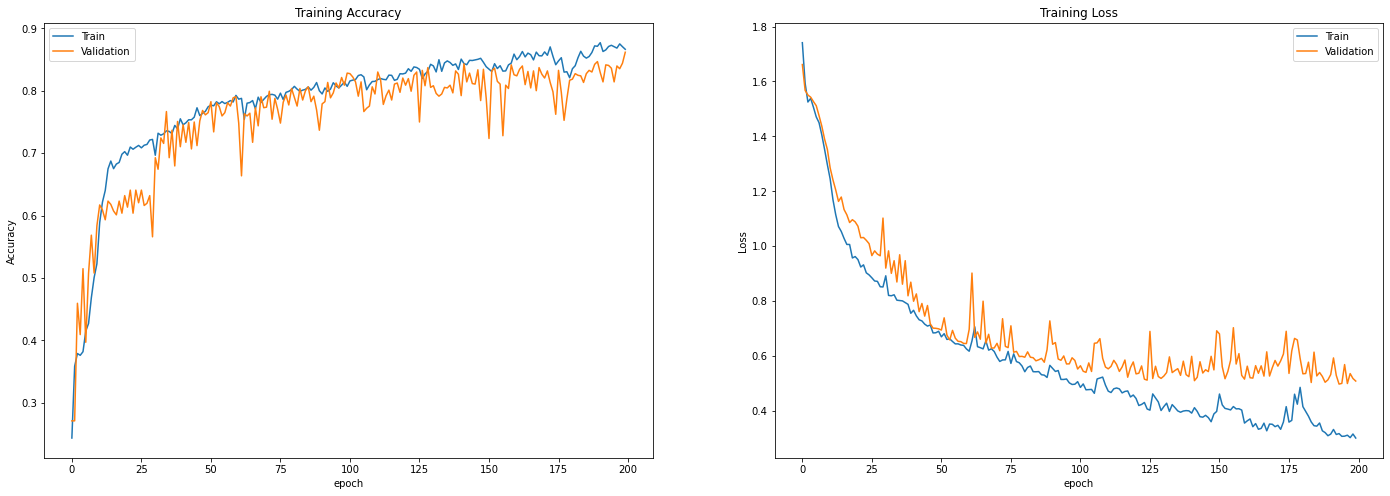

In [26]:
plt.rcParams['figure.figsize'] = (24, 8)
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.title('Training Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['Train','Validation']);

Ok, that looks good. Lets have a look at the confusion matrix.

In [27]:
y_pred = model.predict_classes(X_validation)
y_true = np.argmax(y_validation, axis=1)

pd.DataFrame(confusion_matrix(y_pred, y_true),
             columns= ['predicted_a',  'predicted_b', 'predicted_c', 'predicted_d',  'predicted_e',  'predicted_f'],
             index=['true_a',  'true_b', 'true_c', 'true_d',  'true_e',  'true_f'])

/Users/edd/opt/anaconda3/envs/ame/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,predicted_a,predicted_b,predicted_c,predicted_d,predicted_e,predicted_f
true_a,305,0,17,2,0,0
true_b,0,402,23,20,0,0
true_c,3,27,80,34,0,0
true_d,0,14,13,42,0,0
true_e,0,0,0,1,101,0
true_f,0,0,1,0,2,49


With b,c and d modes there is poor separation from the model results.  However, we have good separation of the e and f classes. 

As there are only a few mis-classifications for e and f modes, the recommendation is that this model can be put into production.